In [1]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as T

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
transformations = T.Compose([T.ToTensor(), T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

In [4]:
train_set = torchvision.datasets.CIFAR10(root="cifar10", train=True, download=True, transform=transformations)
test_set = torchvision.datasets.CIFAR10(root="cifar10", train=False, download=True, transform=transformations)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=256)

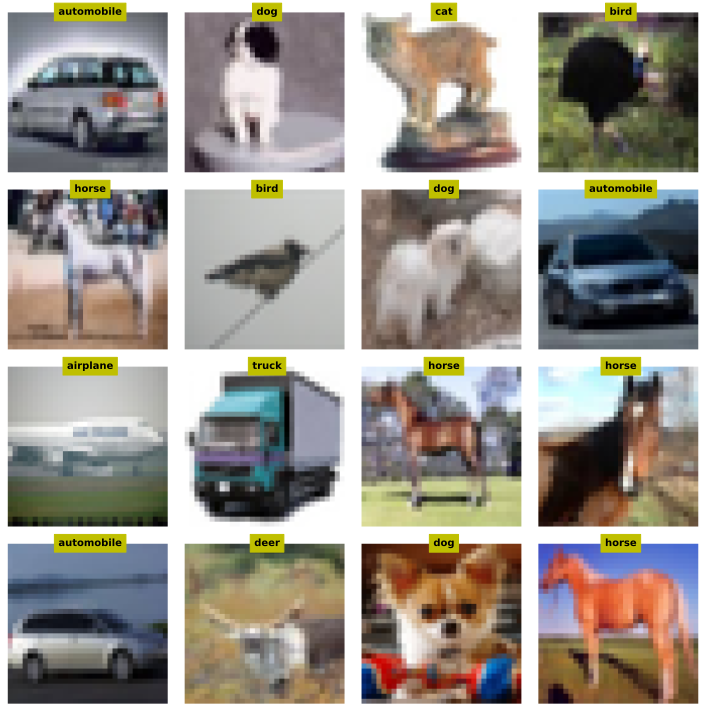

In [6]:
x,y = next(iter(train_loader))

_, axis = plt.subplots(4,4,figsize=(10,10))

for i, ax in enumerate(axis.flatten()):
    pic = x.data[i].numpy().transpose((1,2,0))
    pic = pic/2 + .5
    
    label = train_set.classes[y[i]]
    
    ax.imshow(pic)
    ax.text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    ax.axis('off')

plt.tight_layout();

In [7]:
def model():
    
    class AutoEncoders(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc = nn.Sequential(
                nn.Conv2d(3, 16, 4, 2, 1),
                nn.LeakyReLU(),
                nn.Conv2d(16, 32, 4, 2, 1),
                nn.LeakyReLU()
            )
            
            self.latent = nn.Sequential(
                nn.Conv2d(32, 64, 4, 2, 1),
                nn.ReLU()
            )
            
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(64, 32, 4, 2, 1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(32, 16, 4, 2, 1),
                nn.LeakyReLU(),
                nn.ConvTranspose2d(16, 3, 4, 2, 1),
                nn.LeakyReLU()
            )
            
        def forward(self, x):
            return self.dec(self.latent(self.enc(x)))
        
    autoencoders = AutoEncoders()
    
    loss_fun = nn.MSELoss()
    
    optimizers = torch.optim.Adam(autoencoders.parameters(), lr=0.001)
    
    return autoencoders, loss_fun, optimizers

In [8]:
summary(model()[0].to(device=device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             784
         LeakyReLU-2           [-1, 16, 16, 16]               0
            Conv2d-3             [-1, 32, 8, 8]           8,224
         LeakyReLU-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 4, 4]          32,832
              ReLU-6             [-1, 64, 4, 4]               0
   ConvTranspose2d-7             [-1, 32, 8, 8]          32,800
         LeakyReLU-8             [-1, 32, 8, 8]               0
   ConvTranspose2d-9           [-1, 16, 16, 16]           8,208
        LeakyReLU-10           [-1, 16, 16, 16]               0
  ConvTranspose2d-11            [-1, 3, 32, 32]             771
        LeakyReLU-12            [-1, 3, 32, 32]               0
Total params: 83,619
Trainable params: 83,619
Non-trainable params: 0
---------------------------------

In [9]:
def train_model():
    
    num_epochs = 30

    autoencoders, loss_fun, optimizers = model()
    
    autoencoders.to(device=device)
    
    train_loss = []
    test_loss = []
    
    for epochs in range(num_epochs):
        
        autoencoders.train()
        batch_loss = []
        
        for x, y in train_loader:
            x = x.to(device)
            
            y_hat = autoencoders(x)
            
            loss = loss_fun(y_hat, x)
            
            batch_loss.append(loss.item())
            
            optimizers.zero_grad()
            loss.backward()
            optimizers.step()
            
        train_loss.append(np.mean(batch_loss))
        
        autoencoders.eval()
        
        for x, y in test_loader:
            x = x.to(device)
            
            batch_loss = []
            with torch.no_grad():
                y_hat = autoencoders(x)
                loss =  loss_fun(y_hat, x)
                
            batch_loss.append(loss.item())
            
        test_loss.append(np.mean(batch_loss))
    
    return train_loss, test_loss, autoencoders

In [10]:
train_loss, test_loss, autoencoders = train_model()

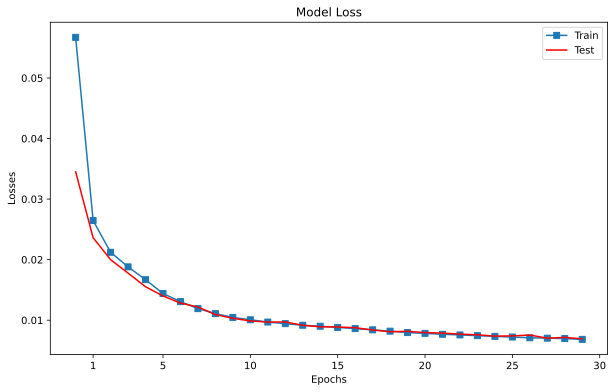

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss, "s-", label="Train")
plt.plot(test_loss, "r-", label="Test")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.xticks([1, 5, 10, 15, 20, 25, 30])
plt.title("Model Loss")
plt.legend();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


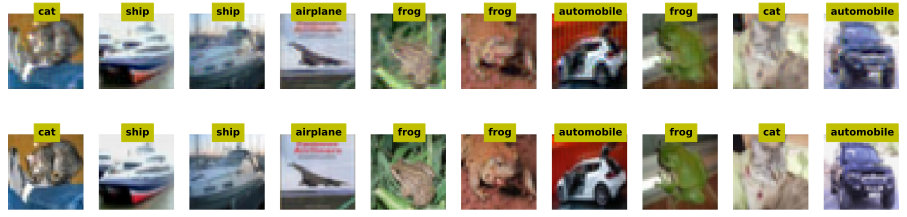

In [15]:
x, y = next(iter(test_loader))
autoencoders.cpu()
autoencoders.eval()
y_hat = autoencoders(x)

_, axis = plt.subplots(2, 10, figsize=(16,4))

for i in range(10):
    pic = y_hat[i, :, :, :].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5

    label = test_set.classes[y[i]]

    axis[0, i].imshow(pic)
    axis[0, i].text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    axis[0, i].axis('off')

    pic = x[i, :, :, :].detach().numpy().transpose((1,2,0))
    pic = pic/2 + .5

    label = test_set.classes[y[i]]

    axis[1, i].imshow(pic)
    axis[1, i].text(16,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
    axis[1, i].axis('off')

plt.show()